## Unit root testing
1. [Abbreviations & definitions](#abreviations_definitions)
2. [Load and inspect](#load_and_inspect)
3. [Augmented Dicky-Fuller test](#ADF_test)
4. [Kwiatkowski-Phillips-Schmidt-Shin test](#KPSS_test)
5. [TODO](#TODO)

<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count

<a name="load_and_inspect"></a>
### 2. Load and inspect

In [21]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf
import functions.plotting_functions as plot_funcs

#import numpy as np
import pandas as pd
import matplotlib
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

print(f'Python: {sys.version}')
print()
#print(f'Numpy {np.__version__}')
print(f'Pandas {pd.__version__}')
print(f'Matplotlib: {matplotlib.__version__}') # type: ignore
print(f'Statsmodels: {sm.__version__}')

# Replace matplotlib with pyplot interface
del matplotlib
import matplotlib.pyplot as plt

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Pandas 1.4.3
Matplotlib: 3.6.3
Statsmodels: 0.13.2


In [22]:
# Read zipped csv into pandas dataframe
training_df = pd.read_csv(f'{conf.KAGGLE_DATA_PATH}/train.csv.zip', compression='zip')

# Set dtype on first day of month column
training_df['first_day_of_month'] =  pd.to_datetime(training_df['first_day_of_month'])

# Print out some metadata and sample rows
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 122265 non-null  object        
 1   cfips                  122265 non-null  int64         
 2   county                 122265 non-null  object        
 3   state                  122265 non-null  object        
 4   first_day_of_month     122265 non-null  datetime64[ns]
 5   microbusiness_density  122265 non-null  float64       
 6   active                 122265 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.5+ MB


<a name="ADF_test"></a>
### 3. Augmented Dicky-Fuller test

1. **H<sub>0</sub>**: The series has a unit root.
2. **H<sub>A</sub>**: The series has no unit root.

In [23]:
# Get list of unique cfips
cfips_list = training_df['cfips'].drop_duplicates(keep='first').to_list()

# Holder for results
pvals = {
    'cfips': [],
    'ADF_pval': []
}

# Loop on counties and ADF test each
for cfips in cfips_list:
    timeseries = training_df[training_df['cfips'] == cfips]
    
    pvals['cfips'].append(cfips)
    
    result = adfuller(timeseries['microbusiness_density'], autolag='AIC')
    pvals['ADF_pval'].append(result[1])

pvals_df = pd.DataFrame.from_dict(pvals)

pvals_df['ADF_pval'].describe()

count    3135.000000
mean        0.496025
std         0.319571
min         0.000000
25%         0.208972
50%         0.508429
75%         0.777935
max         1.000000
Name: ADF_pval, dtype: float64

In [24]:
adf_pvals = pvals_df['ADF_pval']
nonzero_pvals = adf_pvals[adf_pvals > 0]

print(f'Non-zero pvalues: {len(nonzero_pvals)}')
print(f'Zero p-values: {len(pvals_df) - len(nonzero_pvals)}')

Non-zero pvalues: 3132
Zero p-values: 3


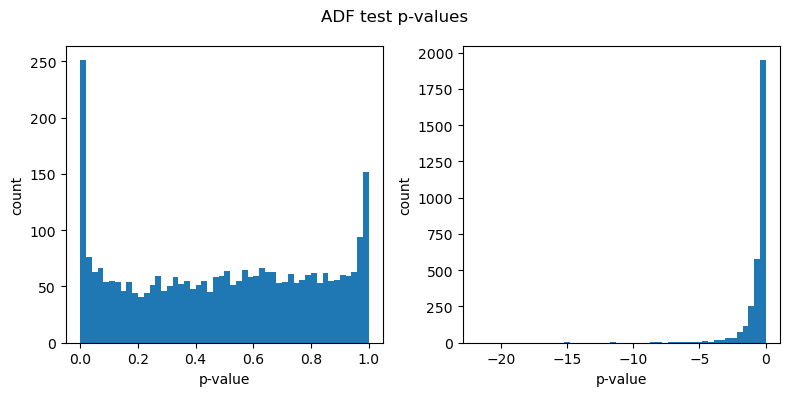

In [25]:
plt = plot_funcs.two_panel_histogram(
    data = nonzero_pvals,
    main_title = 'ADF test p-values',
    linear_plot_x_label = 'p-value',
    log10_plot_x_label = 'p-value',
    bins = 50,
    fig_x_dim = 8,
    fig_y_dim = 4
)

plt.show()

In [32]:
ADF_null_rejected = pvals_df[pvals_df['ADF_pval'] < 0.05].sort_values(['ADF_pval'])
ADF_null_accepted = pvals_df[pvals_df['ADF_pval'] >= 0.05].sort_values(['ADF_pval'], ascending=False)

values = {
    'total_counties': len(pvals_df),
    'ADF_null_rejected_count': len(ADF_null_rejected),
    'ADF_null_accepted_count': len(ADF_null_accepted),
    'ADF_null_rejected_percent': '{0:.1f}'.format((len(ADF_null_rejected) / len(pvals_df)) * 100),
    'ADF_null_accepted_percent': '{0:.1f}'.format((len(ADF_null_accepted) / len(pvals_df)) * 100)
}

string = """
Augmented Dicky-Fuller test results (reject H\N{SUBSCRIPT ZERO} at p < 0.05):

 No evidence for unit root: {ADF_null_rejected_count} counties ({ADF_null_rejected_percent}%)
 Probable unit root: {ADF_null_accepted_count} counties ({ADF_null_accepted_percent}%)
"""

print(string.format(**values))


Augmented Dicky-Fuller test results (reject H₀ at p < 0.05):

 No evidence for unit root: 359 counties (11.5%)
 Probable unit root: 2776 counties (88.5%)



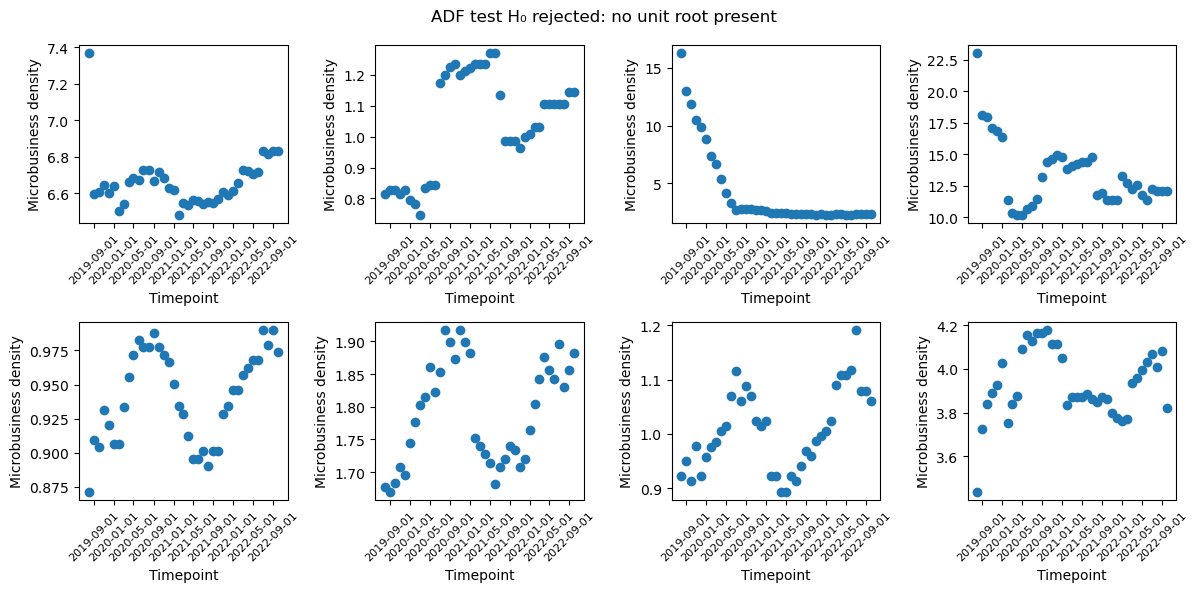

In [27]:
plt = plot_funcs.n_by_n_regression_plot(
    input_data = training_df,
    x_variable = 'first_day_of_month',
    xlabel = 'Timepoint',
    cfips_list = ADF_null_rejected['cfips'].to_list(),
    rows = 2,
    columns = 4,
    main_title = 'ADF test H\N{SUBSCRIPT ZERO} rejected: no unit root present'
)

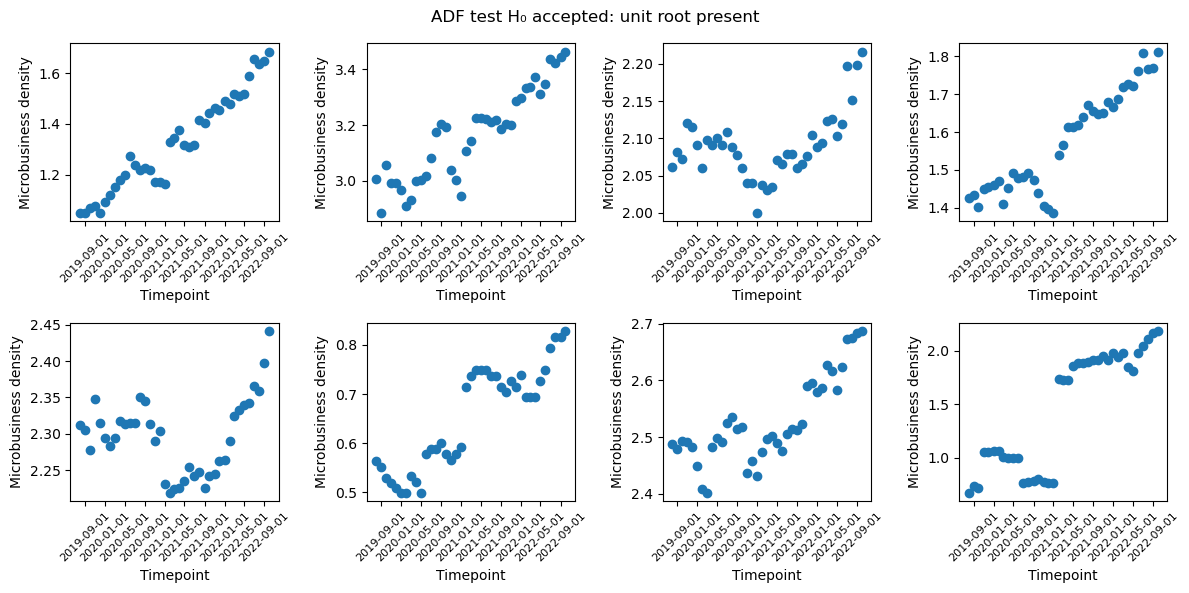

In [28]:
plt = plot_funcs.n_by_n_regression_plot(
    input_data = training_df,
    x_variable = 'first_day_of_month',
    xlabel = 'Timepoint',
    cfips_list = ADF_null_accepted['cfips'].to_list(),
    rows = 2,
    columns = 4,
    main_title = 'ADF test H\N{SUBSCRIPT ZERO} accepted: unit root present'
)

<a name="KPSS_test"></a>
### 4. Kwiatkowski-Phillips-Schmidt-Shin test

1. **H<sub>0</sub>**: The process is trend stationary.
2. **H<sub>A</sub>**: The series has a unit root (series is not stationary).

In [33]:
# Add column to holder for results
pvals['KPSS_pval'] = []

# Loop on counties and KPSS test each
for cfips in cfips_list:
    timeseries = training_df[training_df['cfips'] == cfips]

    kpss_test_result = kpss(timeseries['microbusiness_density'], regression='c', nlags='auto')
    pvals['KPSS_pval'].append(kpss_test_result[1])

pvals_df = pd.DataFrame.from_dict(pvals)
pvals_df['KPSS_pval'].describe()

/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: 

count    3135.000000
mean        0.045312
std         0.037969
min         0.010000
25%         0.010001
50%         0.023991
75%         0.100000
max         0.100000
Name: KPSS_pval, dtype: float64

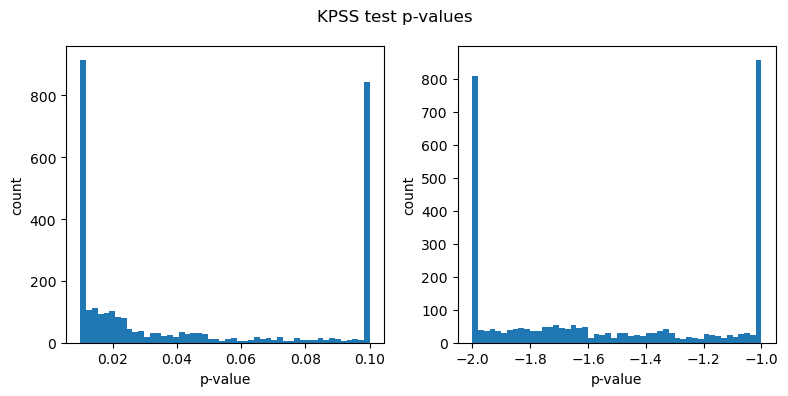

In [12]:
plt = plot_funcs.two_panel_histogram(
    data = pvals_df['KPSS_pval'],
    main_title = 'KPSS test p-values',
    linear_plot_x_label = 'p-value',
    log10_plot_x_label = 'p-value',
    bins = 50,
    fig_x_dim = 8,
    fig_y_dim = 4
)

plt.show()

In [35]:
KPSS_null_rejected = pvals_df[pvals_df['KPSS_pval'] < 0.05].sort_values(['KPSS_pval'])
KPSS_null_accepted = pvals_df[pvals_df['KPSS_pval'] >= 0.05].sort_values(['KPSS_pval'], ascending=False)

values = {
    'total_counties': len(pvals_df),
    'KPSS_null_rejected_count': len(KPSS_null_rejected),
    'KPSS_null_accepted_count': len(KPSS_null_accepted),
    'KPSS_null_rejected_percent': '{0:.1f}'.format((len(KPSS_null_rejected) / len(pvals_df)) * 100),
    'KPSS_null_accepted_percent': '{0:.1f}'.format((len(KPSS_null_accepted) / len(pvals_df)) * 100)
}

string = """
Augmented Kwiatkowski-Phillips-Schmidt-Shin test results (reject H\N{SUBSCRIPT ZERO} at p < 0.05):

 No evidence for trend stationarity: {KPSS_null_rejected_count} counties ({KPSS_null_rejected_percent}%)
 Probable trend stationarity: {KPSS_null_accepted_count} counties ({KPSS_null_accepted_percent}%)
"""

print(string.format(**values))


Augmented Kwiatkowski-Phillips-Schmidt-Shin test results (reject H₀ at p < 0.05):

 No evidence for trend stationarity: 2007 counties (64.0%)
 Probable trend stationarity: 1128 counties (36.0%)



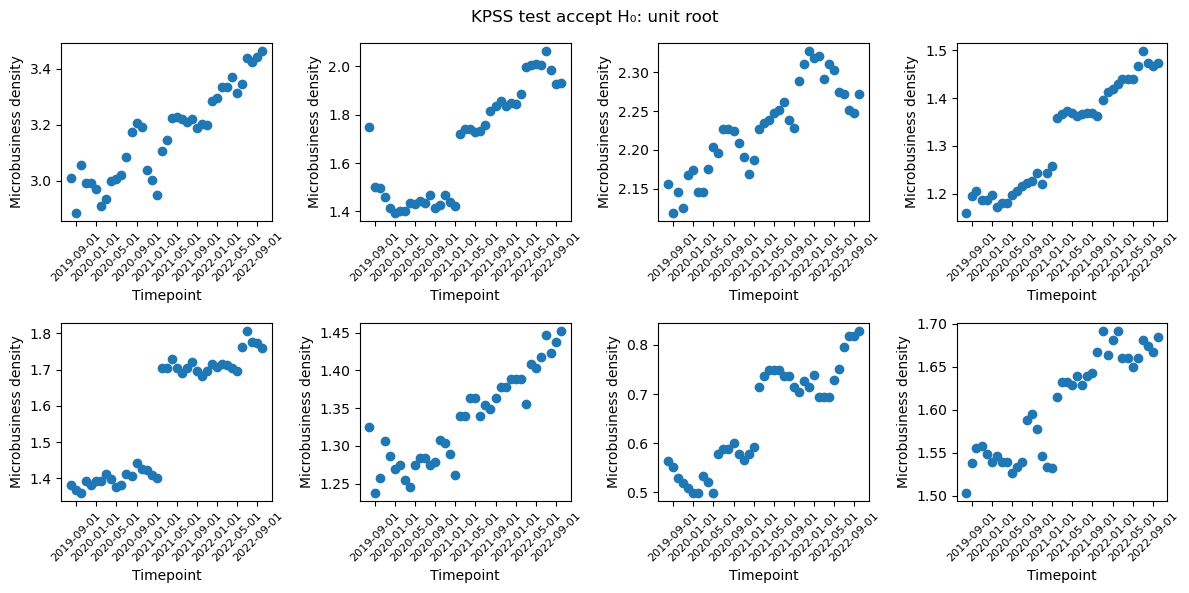

In [13]:
plt = plot_funcs.n_by_n_regression_plot(
    input_data = training_df,
    x_variable = 'first_day_of_month',
    xlabel = 'Timepoint',
    cfips_list = KPSS_null_accepted['cfips'].to_list(),
    rows = 2,
    columns = 4,
    main_title = 'KPSS test accept H\N{SUBSCRIPT ZERO}: unit root'
)

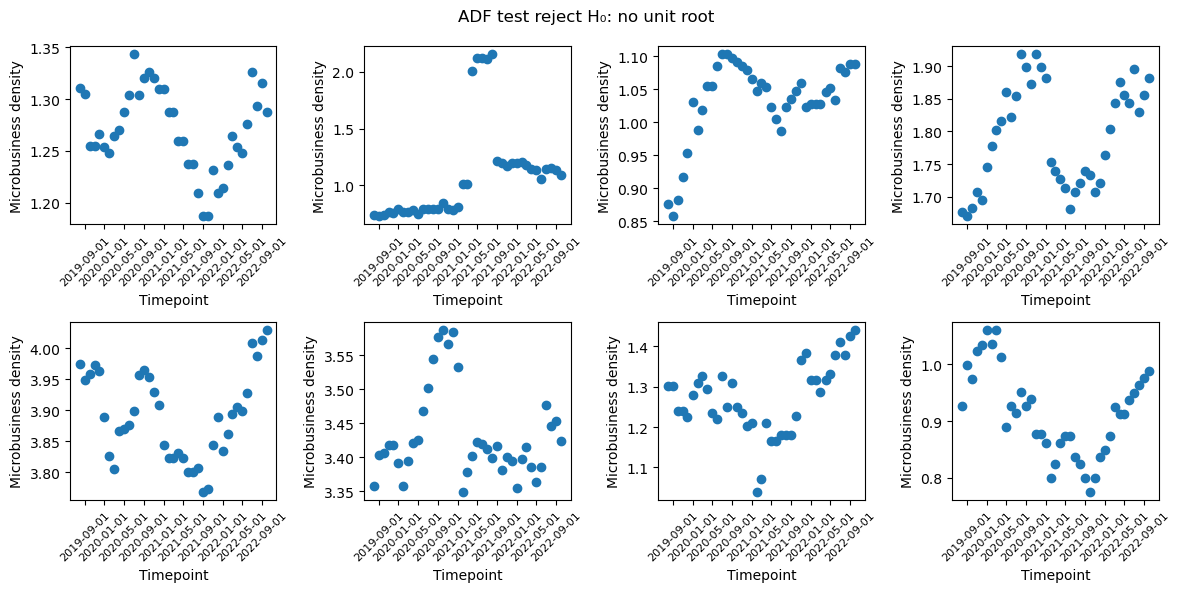

In [14]:
plt = plot_funcs.n_by_n_regression_plot(
    input_data = training_df,
    x_variable = 'first_day_of_month',
    xlabel = 'Timepoint',
    cfips_list = KPSS_null_rejected['cfips'].to_list(),
    rows = 2,
    columns = 4,
    main_title = 'ADF test reject H\N{SUBSCRIPT ZERO}: no unit root'
)

In [37]:
pvals_df['ADF_null_hypothesis'] = 'accept'
pvals_df.loc[pvals_df['ADF_pval'] < 0.05, 'ADF_null_hypothesis'] = 'reject'

pvals_df['KPSS_null_hypothesis'] = 'accept'
pvals_df.loc[pvals_df['KPSS_pval'] < 0.05, 'KPSS_null_hypothesis'] = 'reject'

pvals_df.head()

,cfips,ADF_pval,KPSS_pval,ADF_null_hypothesis,KPSS_null_hypothesis
0,1001,0.994140,0.010000,accept,reject
1,1003,0.429866,0.029614,accept,reject
2,1005,0.464428,0.010000,accept,reject
3,1007,0.065023,0.100000,accept,accept
4,1009,0.690563,0.010000,accept,reject


In [45]:
table_data = pvals_df[['ADF_null_hypothesis', 'KPSS_null_hypothesis']]
table = sm.stats.Table.from_data(table_data)
print(table.table_orig)

KPSS_null_hypothesis  accept  reject
ADF_null_hypothesis                 
accept                   897    1879
reject                   231     128


<a name="TODO"></a>
### 5. TODO
1. Check interpretation of null hypothesis.
2. Make 'confusion-matrix' style plot showing how many counties accept/reject H<sub>0</sub> for each test.
4. Add difference de-trending (whole dataset? just relevant counties?).